# tfrecord实践

## 制作tfrecord
https://www.cnblogs.com/wj-1314/p/11211333.html
https://blog.csdn.net/weixin_39190382/article/details/104348060

In [2]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [6]:
# 保证sess.run()能够正常运行
tf.compat.v1.disable_eager_execution() 

In [7]:

 
def write_test(input, output):
    # 借助于TFRecordWriter 才能将信息写入TFRecord 文件
    writer = tf.io.TFRecordWriter(output)
 
    # 读取图片并进行解码
    image = tf.io.read_file(input)
    image = tf.image.decode_jpeg(image)
 
    with tf.compat.v1.Session() as sess:
        image = sess.run(image)
        shape = image.shape
        # 将图片转换成string
        image_data = image.tostring()
        print(type(image))
        print(len(image_data))
        name = bytes('cat', encoding='utf-8')
        print(type(name))
        # 创建Example对象，并将Feature一一对应填充进去
        example = tf.train.Example(features=tf.train.Features(feature={
             'name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[name])),
             'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=[shape[0], shape[1], shape[2]])),
             'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data]))
        }
        ))
        # 将example序列化成string 类型，然后写入。
        writer.write(example.SerializeToString())
    writer.close()
 
 
if __name__ == '__main__':
    input_photo = 'cat.jpg'
    output_file = 'cat.tfrecord'
    write_test(input_photo, output_file)

<class 'numpy.ndarray'>
601500
<class 'bytes'>


<class 'numpy.ndarray'>
601500


/Users/didi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


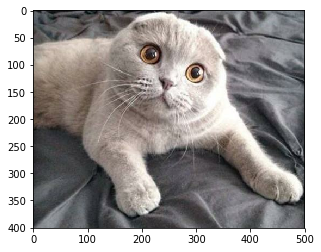

In [14]:
import numpy as np
import matplotlib.pyplot as plt
 
def _parse_record(example_photo):
    features = {
        'name': tf.io.FixedLenFeature((), tf.string),
        'shape': tf.io.FixedLenFeature([3], tf.int64),
        'data': tf.io.FixedLenFeature((), tf.string)
    }
    parsed_features = tf.io.parse_single_example(example_photo,features=features)
    return parsed_features
 
def read_test(input_file):
    # 用dataset读取TFRecords文件
    dataset = tf.compat.v1.data.TFRecordDataset(input_file)
    dataset = dataset.map(_parse_record)
    # tensorflow1.X版本写法data_it = dataset.make_one_shot_iterator()
   # tensorflow2.X版本写法data_it = tf.compat.v1.data.make_one_shot_iterator(dataset)
    iterator = dataset.make_one_shot_iterator()
 
    with tf.compat.v1.Session() as sess:
        features = sess.run(iterator.get_next())
        name = features['name']
        name = name.decode()
        img_data = features['data']
        shape = features['shape']
        print("==============")
        print(type(shape))
        print(len(img_data))
 
        # 从bytes数组中加载图片原始数据，并重新reshape，它的结果是 ndarray 数组
        img_data = np.fromstring(img_data, dtype=np.uint8)
        image_data = np.reshape(img_data, shape)
 
        plt.figure()
        # 显示图片
        plt.imshow(image_data)
        plt.show()
 
        # 将数据重新编码成jpg图片并保存
        img = tf.image.encode_jpeg(image_data)
        tf.io.gfile.GFile('cat_encode.jpg', 'wb').write(img.eval())
 
if __name__ == '__main__':
    read_test("cat.tfrecord")

## 将图片保存成TFRecords

In [ ]:

import os
from PIL import Image
import random
import cv2
import numpy as np
 
 
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
 
 
# 生成字符串型的属性
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
 
 
# 生成实数型的属性
def float_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))
 
 
def read_image(filename, resize_height, resize_width, normalization=False):
    '''
        读取图片数据，默认返回的是uint8, [0, 255]
        :param filename:
        :param resize_height:
        :param resize_width:
        :param normalization:  是否归一化到 [0.0, 1.0]
        :return:  返回的图片数据
        '''
    bgr_image = cv2.imread(filename)
    # print(type(bgr_image))
    # 若是灰度图则转化为三通道
    if len(bgr_image.shape) == 2:
        print("Warning:gray image", filename)
        bgr_image = cv2.cvtColor(bgr_image, cv2.COLOR_GRAY2BGR)
    # 将BGR转化为RGB
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    # show_image(filename, rgb_image)
    # rgb_image=Image.open(filename)
    if resize_width > 0 and resize_height > 0:
        rgb_image = cv2.resize(rgb_image, (resize_width, resize_height))
    rgb_image = np.asanyarray(rgb_image)
    if normalization:
        rgb_image = rgb_image / 255.0
    return rgb_image
 
 
def load_labels_file(filename, labels_num=1, shuffle=False):
    '''
        载图txt文件，文件中每行为一个图片信息，且以空格隔开，图像路径 标签1  标签2
        如  test_image/1.jpg 0 2
        :param filename:
        :param labels_num:  labels个数
        :param shuffle: 是否打乱顺序
        :return:  images type-> list
        :return：labels type->lis\t
        '''
    images = []
    labels = []
    with open(filename) as f:
        lines_list = f.readlines()
        # print(lines_list)  # ['plane\\0499.jpg 4\n', 'plane\\0500.jpg 4\n']
        if shuffle:
            random.shuffle(lines_list)
        for lines in lines_list:
            line = lines.rstrip().split(" ")  # rstrip 删除 string 字符串末尾的空格.  ['plane\\0006.jpg', '4']
            label = []
            for i in range(labels_num):  # labels_num 1      0 1所以i只能取1
                label.append(int(line[i + 1]))  # 确保读取的是列表的第二个元素
            # print(label)
            images.append(line[0])
            # labels.append(line[1])  # ['0', '4']
            labels.append(label)
    # print(images)
    # print(labels)
    return images, labels
 
 
def create_records(image_dir, file, output_record_dir, resize_height, resize_width, shuffle, log=5):
    '''
    实现将图像原始数据,label,长,宽等信息保存为record文件
    注意:读取的图像数据默认是uint8,再转为tf的字符串型BytesList保存,解析请需要根据需要转换类型
    :param image_dir:原始图像的目录
    :param file:输入保存图片信息的txt文件(image_dir+file构成图片的路径)
    :param output_record_dir:保存record文件的路径
    :param resize_height:
    :param resize_width:
    PS:当resize_height或者resize_width=0是,不执行resize
    :param shuffle:是否打乱顺序
    :param log:log信息打印间隔
    '''
    # 加载文件，仅获取一个label
    images_list, labels_list = load_labels_file(file, 1, shuffle)
 
    writer = tf.python_io.TFRecordWriter(output_record_dir)
    for i, [image_name, labels] in enumerate(zip(images_list, labels_list)):
        image_path = os.path.join(image_dir, images_list[i])
        if not os.path.exists(image_path):
            print("Error:no image", image_path)
            continue
        image = read_image(image_path, resize_height, resize_width)
        image_raw = image.tostring()
        if i % log == 0 or i == len(images_list) - 1:
            print("-----------processing:%d--th------------" % (i))
            print('current image_path=%s' % (image_path), 'shape:{}'.format(image.shape),
                  'labels:{}'.format(labels))
        # 这里仅保存一个label,多label适当增加"'label': _int64_feature(label)"项
        label = labels[0]
        example = tf.train.Example(features=tf.train.Features(feature={
            'image_raw': _bytes_feature(image_raw),
            'height': _int64_feature(image.shape[0]),
            'width': _int64_feature(image.shape[1]),
            'depth': _int64_feature(image.shape[2]),
            'label': _int64_feature(label)
        }))
        writer.write(example.SerializeToString())
    writer.close()
 
def get_example_nums(tf_records_filenames):
    '''
    统计tf_records图像的个数(example)个数
    :param tf_records_filenames: tf_records文件路径
    :return:
    '''
    nums = 0
    for record in tf.python_io.tf_record_iterator(tf_records_filenames):
        nums += 1
    return nums
 
if __name__ == '__main__':
    resize_height = 224  # 指定存储图片高度
    resize_width = 224  # 指定存储图片宽度
    shuffle = True
    log = 5
 
    image_dir = 'dataset/train'
    train_labels = 'dataset/train.txt'
    train_record_output = 'train.tfrecord'
    create_records(image_dir, train_labels, train_record_output, resize_height, resize_width, shuffle, log)
    train_nums = get_example_nums(train_record_output)
    print("save train example nums={}".format(train_nums))

In [ ]:
# 将图片保存成TFRecords

In [ ]:

import os
import tensorflow as tf
from PIL import Image
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
def read_records(filename,resize_height, resize_width,type=None):
    '''
    解析record文件:源文件的图像数据是RGB,uint8,[0,255],一般作为训练数据时,需要归一化到[0,1]
    :param filename:
    :param resize_height:
    :param resize_width:
    :param type:选择图像数据的返回类型
         None:默认将uint8-[0,255]转为float32-[0,255]
         normalization:归一化float32-[0,1]
         centralization:归一化float32-[0,1],再减均值中心化
    :return:
    '''
    # 创建文件队列，不限读取的数量
    filename_queue = tf.train.string_input_producer([filename])
    # 为文件队列创建一个阅读区
    reader = tf.TFRecordReader()
    # reader从文件队列中读入一个序列化的样本
    _, serialized_example = reader.read(filename_queue)
 
    # 解析符号化的样本
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'depth': tf.FixedLenFeature([], tf.int64),
            'label': tf.FixedLenFeature([], tf.int64)
        }
    )
    # 获得图像原始的数据
    tf_image = tf.decode_raw(features["image_raw"], tf.uint8)
 
    tf_height = features['height']
    tf_width = features['width']
    tf_depth = features['depth']
    tf_label = tf.cast(features['label'], tf.int32)
 
    #PS 回复原始图像 reshpe的大小必须与保存之前的图像shape一致，否则报错
    # 设置图像的维度
    tf_image = tf.reshape(tf_image, [resize_height, resize_width, 3])
 
    # 恢复数据后，才可以对图像进行resize_images:输入 uint 输出 float32
    # tf_image = tf.image.resize_images(tf_image, [224, 224])
 
    # 存储的图像类型为 uint8 tensorflow训练数据必须是tf.float32
    if type is None:
        tf_image = tf.cast(tf_image, tf.float32)
    # 【1】 若需要归一化的话请使用
    elif type == 'normalization':
        # 仅当输入数据是 uint8，才会归一化 [0 , 255]
        tf_image = tf.cast(tf_image, tf.float32) * (1. / 255.0)
    elif type=='centralization':
        # 若需要归一化，且中心化，假设均值为0.5 请使用
        tf_image = tf.cast(tf_image, tf.float32) * (1. / 255.0) - 0.5
 
    # 这里仅仅返回图像和标签
    return tf_image, tf_label
 
 
def show_image(title, image):
    '''
    显示图片
    :param title:  图像标题
    :param image:  图像的数据
    :return:
    '''
    plt.imshow(image)
    plt.axis('on')   # 关掉坐标轴 为  off
    plt.title(title)  # 图像题目
    plt.show()
 
 
def disp_records(record_file,resize_height, resize_width,show_nums=4):
    '''
    解析record文件，并显示show_nums张图片，主要用于验证生成record文件是否成功
    :param tfrecord_file: record文件路径
    :return:
    '''
    # 读取record 函数
    tf_image, tf_label = read_records(record_file, resize_height, resize_width, type='normalization')
    # 显示前4个图片
    init_op = tf.global_variables_initializer()
    # init_op = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        for i in range(show_nums):  # 在会话中取出image和label
            image, label = sess.run([tf_image, tf_label])
            # image = tf_image.eval()
            # 直接从record解析的image是一个向量,需要reshape显示
            # image = image.reshape([height,width,depth])
            print('shape:{},tpye:{},labels:{}'.format(image.shape, image.dtype, label))
            # pilimg = Image.fromarray(np.asarray(image_eval_reshape))
            # pilimg.show()
            show_image("image:%d"%(label), image)
        coord.request_stop()
        coord.join(threads)
 
 
if __name__ == '__main__':
    resize_height = 224  # 指定存储图片高度
    resize_width = 224  # 指定存储图片宽度
    shuffle = True
    log = 5
 
    image_dir = 'dataset/train'
    train_labels = 'dataset/train.txt'
    train_record_output = 'train.tfrecord'
 
 
    # 测试显示函数
    disp_records(train_record_output, resize_height, resize_width)

In [2]:
import tensorflow as tf
import numpy as np
import IPython.display as display
tf.__version__

'2.3.0'

## tensorflow tfrecord
* https://tensorflow.google.cn/tutorials/load_data/tfrecord?hl=zh-cn

In [10]:
def _bytes_feature(value):
    if isinstance(value,type(tf.constant(0))):
        value=value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [11]:
print(_bytes_feature(b'test_string'))
print(_bytes_feature(u'test_bytes'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



In [12]:
feature=_float_feature(np.exp(1))
feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

In [15]:
help(np.random.choice)

Help on built-in function choice:

choice(...) method of numpy.random.mtrand.RandomState instance
    choice(a, size=None, replace=True, p=None)
    
    Generates a random sample from a given 1-D array
    
            .. versionadded:: 1.7.0
    
    .. note::
        New code should use the ``choice`` method of a ``default_rng()``
        instance instead; see `random-quick-start`.
    
    Parameters
    ----------
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if a were np.arange(a)
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement
    p : 1-D array-like, optional
        The probabilities associated with each entry i

In [17]:
import numpy as np

# 参数意思分别 是从a 中以概率P，随机选择3个, p没有指定的时候相当于是一致的分布
a1 = np.random.choice(a=5, size=3, replace=False, p=None)
print(a1)
# 非一致的分布，会以多少的概率提出来
a2 = np.random.choice(a=5, size=3, replace=False, p=[0.2, 0.1, 0.3, 0.4, 0.0])
print(a2)
# replacement 代表的意思是抽样之后还放不放回去，如果是False的话，那么出来的三个数都不一样，如果是
# True的话， 有可能会出现重复的，因为前面的抽的放回去了。

[4 1 2]
[1 3 0]


In [47]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

feature4 = np.random.randn(n_observations)

In [19]:
feature0

array([False, False, False, ...,  True,  True, False])

In [49]:
def serialize_example(feature0, feature1, feature2, feature3,feature4):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.
    feature = {
    'feature0': _int64_feature(feature0),
    'feature1': _int64_feature(feature1),
    'feature2': _bytes_feature(feature2),
    'feature3': _float_feature(feature3),
    'feature4': _float_feature(feature4)
    }

    # Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [52]:
# This is an example observation from the dataset.

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876,0.9876)
serialized_example

b'\nh\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature4\x12\x08\x12\x06\n\x04[\xd3|?\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?'

In [53]:
example_proto=tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
  feature {
    key: "feature4"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

In [27]:
tf.data.Dataset.from_tensor_slices(feature1)

<TensorSliceDataset shapes: (), types: tf.int64>

In [55]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3,feature4))
features_dataset

<TensorSliceDataset shapes: ((), (), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64, tf.float64)>

In [59]:
 # Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3,f4 in features_dataset.take(1):
    print(f0)
    print(f1)
    print(f2)
    print(f3)
    print(f4)


tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'dog', shape=(), dtype=string)
tf.Tensor(-1.3084512119634855, shape=(), dtype=float64)
tf.Tensor(0.727710629955296, shape=(), dtype=float64)


In [62]:
def tf_serialize_example(f0,f1,f2,f3,f4):
    tf_string = tf.py_function(
        serialize_example,
        (f0,f1,f2,f3,f4),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [63]:
tf_serialize_example(f0,f1,f2,f3,f4)


<tf.Tensor: shape=(), dtype=string, numpy=b'\ng\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04T{\xa7\xbf\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature4\x12\x08\x12\x06\n\x04>K:?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01'>

In [64]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [66]:
def generator():
    for features in features_dataset:
        yield serialize_example(*features)

In [67]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [68]:
serialized_features_dataset

<FlatMapDataset shapes: (), types: tf.string>

In [69]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [70]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [71]:
for raw_record in raw_dataset.take(10):
    print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\ng\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04T{\xa7\xbf\n\x14\n\x08feature4\x12\x08\x12\x06\n\x04>K:?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nk\n\x14\n\x08feature4\x12\x08\x12\x06\n\x04\xd7\x8ci\xbe\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\x1a\xace\xbf\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nh\n\x14\n\x08feature4\x12\x08\x12\x06\n\x04\xe7f\xb0?\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x01\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xcf\xde\x9d>'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\ng\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x14\n\x08feature4\x12\x08\x12\x

In [72]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [73]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

In [75]:
# Write the `tf.Example` observations to the file.
with tf.io.TFRecordWriter(filename) as writer:
    for i in range(n_observations):
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i],feature4[i])
        writer.write(example)

In [76]:
!du -sh {filename}

2.1M	test.tfrecord


In [77]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [45]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)
    

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 2
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "chicken"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.3172130584716797
      }
    }
  }
}

